In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import datetime

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', 200)

In [5]:
df_train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [6]:
df_test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [7]:
# заполним пропуски модой
df_train.education.fillna(df_train.education.mode()[0], inplace=True)
df_test.education.fillna(df_test.education.mode()[0], inplace=True)

In [8]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']

In [9]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])
    df_train[column] = label_encoder.fit_transform(df_train[column])
df_test.education = pd.Series(
    label_encoder.fit_transform(df_test['education']))
df_train.education = pd.Series(
    label_encoder.fit_transform(df_train['education']))

In [10]:
def search_outliers(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    IQR = q3 - q1
    min_ = q1 - 1.5*IQR
    max_ = q3 + 1.5*IQR
    print(
        f'Границы выбросов в столбце - [{df.quantile(0.25)-1.5*IQR}; {df.quantile(0.75)+1.5*IQR}]')
    return len(df[df < min_]) + len(df[df > max_])

In [11]:
def graph(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Histogram, QQ-plot and boxplot')
    ax1.hist(df.dropna(), bins=20, histtype='bar',
             align='mid', rwidth=0.8, color='red')
    fig = sm.qqplot(df.dropna(), fit=True, line='45', ax=ax2)
    ax3.boxplot(df.dropna(), vert=False)  # выбросы
    plt.show()

## FEATURE ENGINEERING

### App_date

In [12]:
df_test['app_date'] = pd.to_datetime(df_test.app_date, format='%d%b%Y')
df_train['app_date'] = pd.to_datetime(df_train.app_date, format='%d%b%Y')

In [13]:
df_test['days_from_now'] = df_test.app_date.apply(
    lambda x: (datetime.datetime.today() - x).days)
df_train['days_from_now'] = df_train.app_date.apply(
    lambda x: (datetime.datetime.today() - x).days)

In [14]:
df_test['day'] = df_test.app_date.dt.day
df_train['day'] = df_train.app_date.dt.day

In [15]:
df_test['month'] = df_test.app_date.dt.month
df_train['month'] = df_train.app_date.dt.month

In [16]:
df_test['weekday'] = df_test.app_date.dt.weekday
df_train['weekday'] = df_train.app_date.dt.weekday

In [17]:
#df['day_name'] = df.app_date.dt.day_name()

ИТОГ:
1. days_from_now - сколько дней прошло до сегодняшней даты 
2. day - календарный день
3. month - номер месяца
4. weekday - день недели

### Age

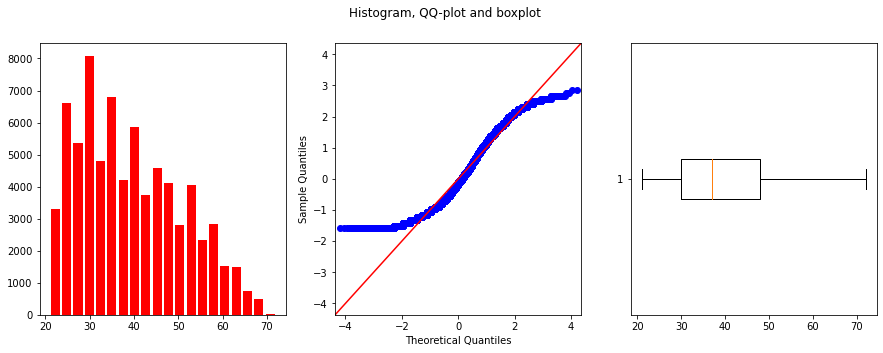

In [18]:
graph(df_train.age)

In [19]:
search_outliers(df_train.age)

Границы выбросов в столбце - [3.0; 75.0]


0

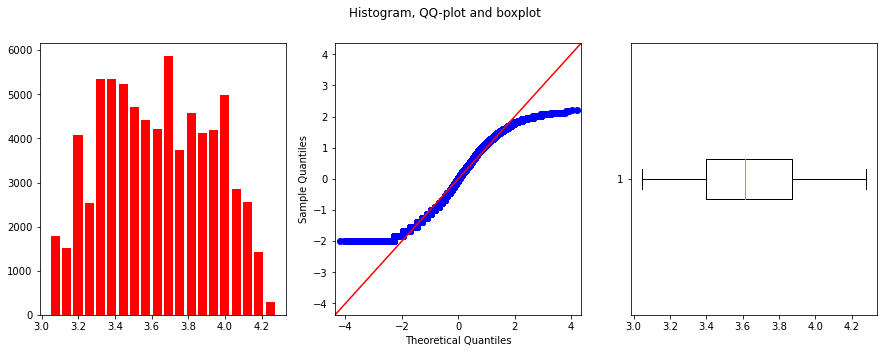

In [20]:
graph(np.log(df_train.age))

In [21]:
df_test.age = np.log(df_test.age)
df_train.age = np.log(df_train.age)

### Decline_app_cnt

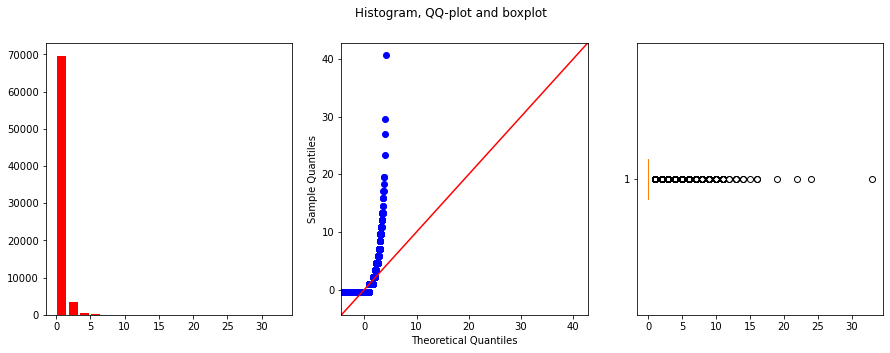

In [22]:
graph(df_train.decline_app_cnt)

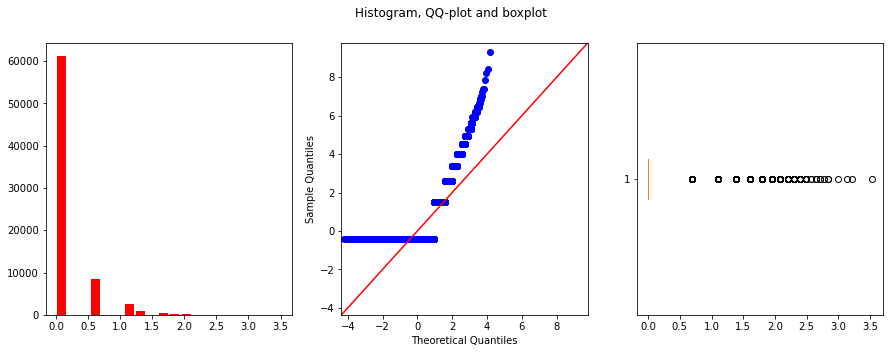

In [23]:
graph(np.log(df_train.decline_app_cnt+1))

In [24]:
search_outliers(df_train.decline_app_cnt)

Границы выбросов в столбце - [0.0; 0.0]


12585

In [25]:
df_test.decline_app_cnt = np.log(df_test.decline_app_cnt+1)
df_train.decline_app_cnt = np.log(df_train.decline_app_cnt+1)

In [26]:
search_outliers(df_train.decline_app_cnt)

Границы выбросов в столбце - [0.0; 0.0]


12585

Выбросы не удаляем, так как тогда этот признак не будет иметь смысла

### Score_bki

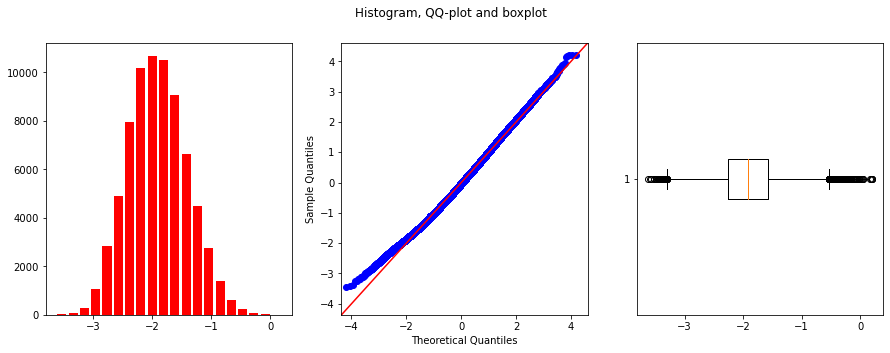

In [27]:
graph(df_train.score_bki)

In [28]:
search_outliers(df_train.score_bki)

Границы выбросов в столбце - [-3.2940876975; -0.5352773974999998]


351

Выбросы удалять не стал, так как у меня нет информации как получен этот признак и какие значения может принимать.

### Bki_request_cnt

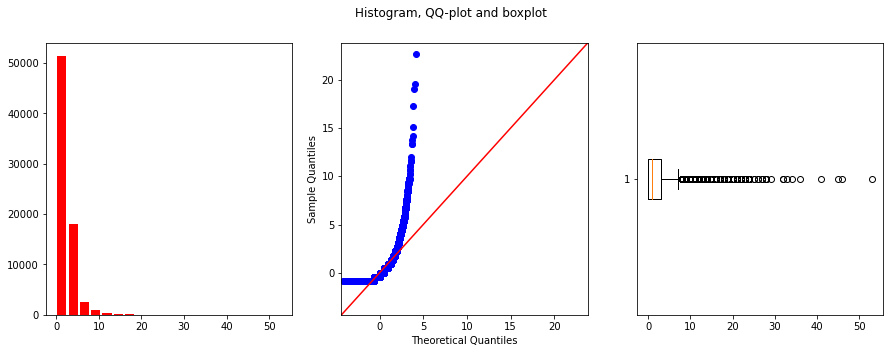

In [29]:
graph(df_train.bki_request_cnt)

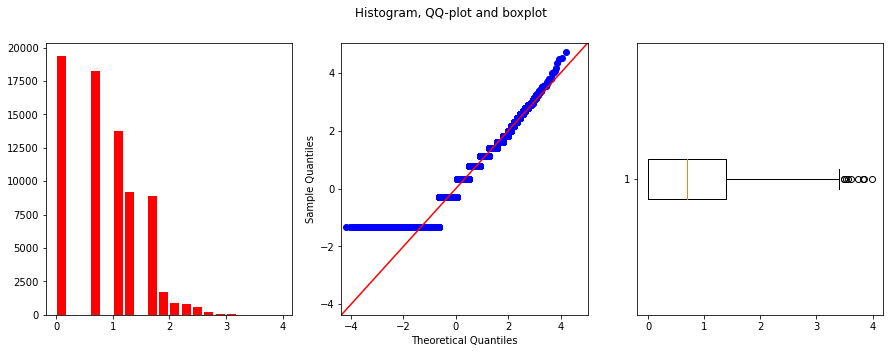

In [30]:
graph(np.log(df_train.bki_request_cnt+1))

In [31]:
search_outliers(df_train.bki_request_cnt)

Границы выбросов в столбце - [-4.5; 7.5]


1755

In [32]:
df_test.bki_request_cnt = np.log(df_test.bki_request_cnt+1)
df_train.bki_request_cnt = np.log(df_train.bki_request_cnt+1)

In [33]:
search_outliers(df_train.bki_request_cnt)

Границы выбросов в столбце - [-2.0794415416798357; 3.465735902799726]


9

In [34]:
# up = np.where(df_train.bki_request_cnt >= 3.465735902799726)[0]
# low = np.where(df_train.bki_request_cnt<=-2.0794415416798357)[0]

In [35]:
# df_train.drop(up, inplace=True)
# df_train.drop(low, inplace=True)

Выбросы не стал удалять, так как ухудшаются показатели модели

### Income

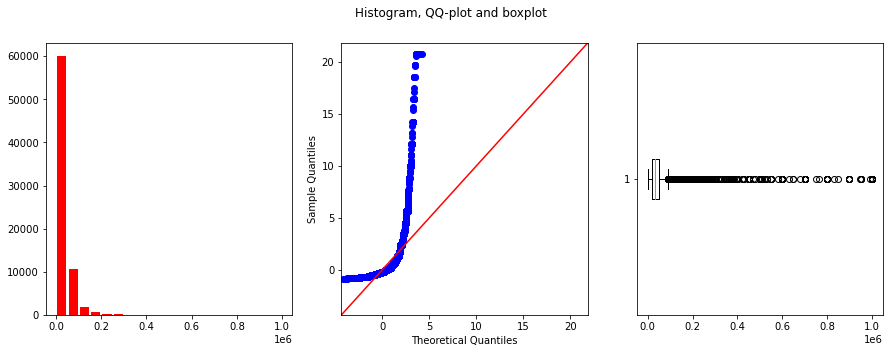

In [36]:
graph(df_train.income)

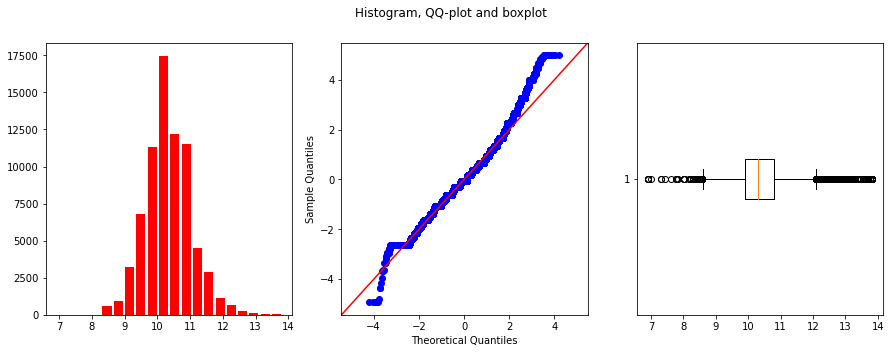

In [37]:
graph(np.log(df_train.income))

In [38]:
search_outliers(df_train.income)

Границы выбросов в столбце - [-22000.0; 90000.0]


4695

In [39]:
df_test.income = np.log(df_test.income)
df_train.income = np.log(df_train.income)

In [40]:
search_outliers(df_train.income)

Границы выбросов в столбце - [8.590284446505276; 12.092159395920877]


1767

In [41]:
# up = np.where(df_train.income >= 12.083681239397592)[0]
# low = np.where(df_train.income<=8.595371340419248)[0]

In [42]:
# df_train.drop(up, inplace=True)
# df_train.drop(low, inplace=True)

Выбросы удалил

In [43]:
mean_income_by_age = df_train.groupby('age').agg({'income': 'mean'})
df_train['mean_income_by_age'] = df_train.age.apply(
    lambda x: mean_income_by_age.loc[x])
num_cols.append('mean_income_by_age')

mean_income_by_age = df_test.groupby('age').agg({'income': 'mean'})
df_test['mean_income_by_age'] = df_test.age.apply(
    lambda x: mean_income_by_age.loc[x])

In [44]:
mean_income_by_home = df_train.groupby('home_address').agg({'income': 'mean'})
df_train['mean_income_by_home'] = df_train.home_address.apply(
    lambda x: mean_income_by_home.loc[x])
num_cols.append('mean_income_by_home')

mean_income_by_home = df_test.groupby('home_address').agg({'income': 'mean'})
df_test['mean_income_by_home'] = df_test.home_address.apply(
    lambda x: mean_income_by_home.loc[x])

In [45]:
mean_income_by_decline_app_cnt = df_train.groupby(
    'decline_app_cnt').agg({'income': 'mean'})
df_train['mean_income_by_decline_app_cnt'] = df_train.decline_app_cnt.apply(
    lambda x: mean_income_by_decline_app_cnt.loc[x])
num_cols.append('mean_income_by_decline_app_cnt')

mean_income_by_decline_app_cnt = df_test.groupby(
    'decline_app_cnt').agg({'income': 'mean'})
df_test['mean_income_by_decline_app_cnt'] = df_test.decline_app_cnt.apply(
    lambda x: mean_income_by_decline_app_cnt.loc[x])

In [46]:
df_train['rich_metric'] = (df_train.age*df_train.income)/10
num_cols.append('rich_metric')

df_test['rich_metric'] = (df_test.age*df_test.income)/10

In [47]:
max_income_age = df_train.groupby('age').agg({'income': 'max'})
df_train['max_income_age'] = df_train.age.apply(
    lambda x: max_income_age.loc[x])
min_income_age = df_train.groupby('age').agg({'income': 'min'})
df_train['min_income_age'] = df_train.age.apply(
    lambda x: min_income_age.loc[x])
num_cols.append('max_income_age')
num_cols.append('min_income_age')

max_income_age = df_test.groupby('age').agg({'income': 'max'})
df_test['max_income_age'] = df_test.age.apply(lambda x: max_income_age.loc[x])
min_income_age = df_test.groupby('age').agg({'income': 'min'})
df_test['min_income_age'] = df_test.age.apply(lambda x: min_income_age.loc[x])

In [48]:
df_train['normalized_income_by_age'] = (df_train.income - df_train.mean_income_by_age)/(
    df_train.max_income_age-df_train.min_income_age + 0.0000001)
num_cols.append('normalized_income_by_age')

df_test['normalized_income_by_age'] = (df_test.income - df_test.mean_income_by_age)/(
    df_test.max_income_age-df_test.min_income_age + 0.0000001)

<AxesSubplot:>

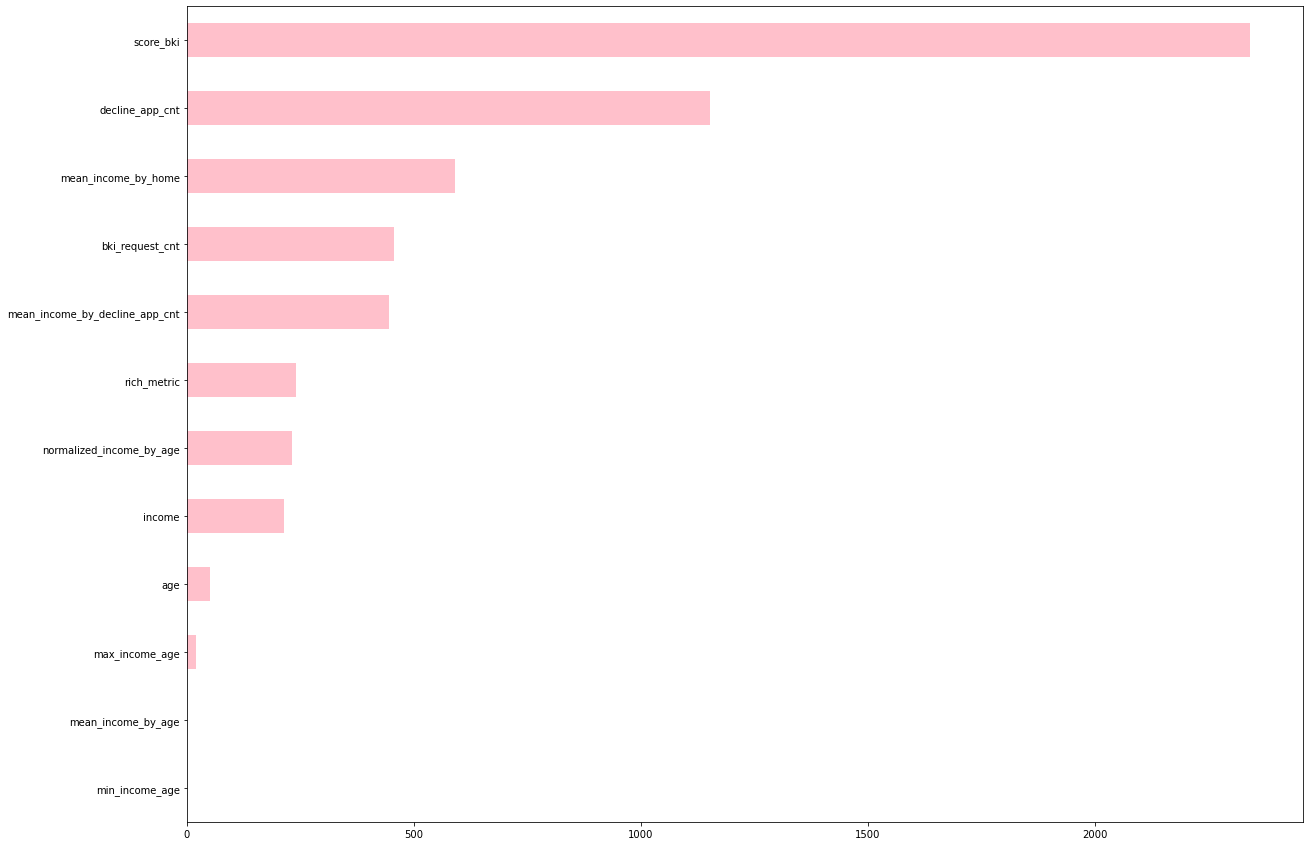

In [49]:
plt.figure(figsize=[20, 15])
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', color='pink')

<AxesSubplot:>

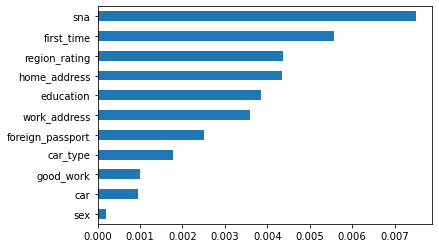

In [50]:
imp_cat = pd.Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

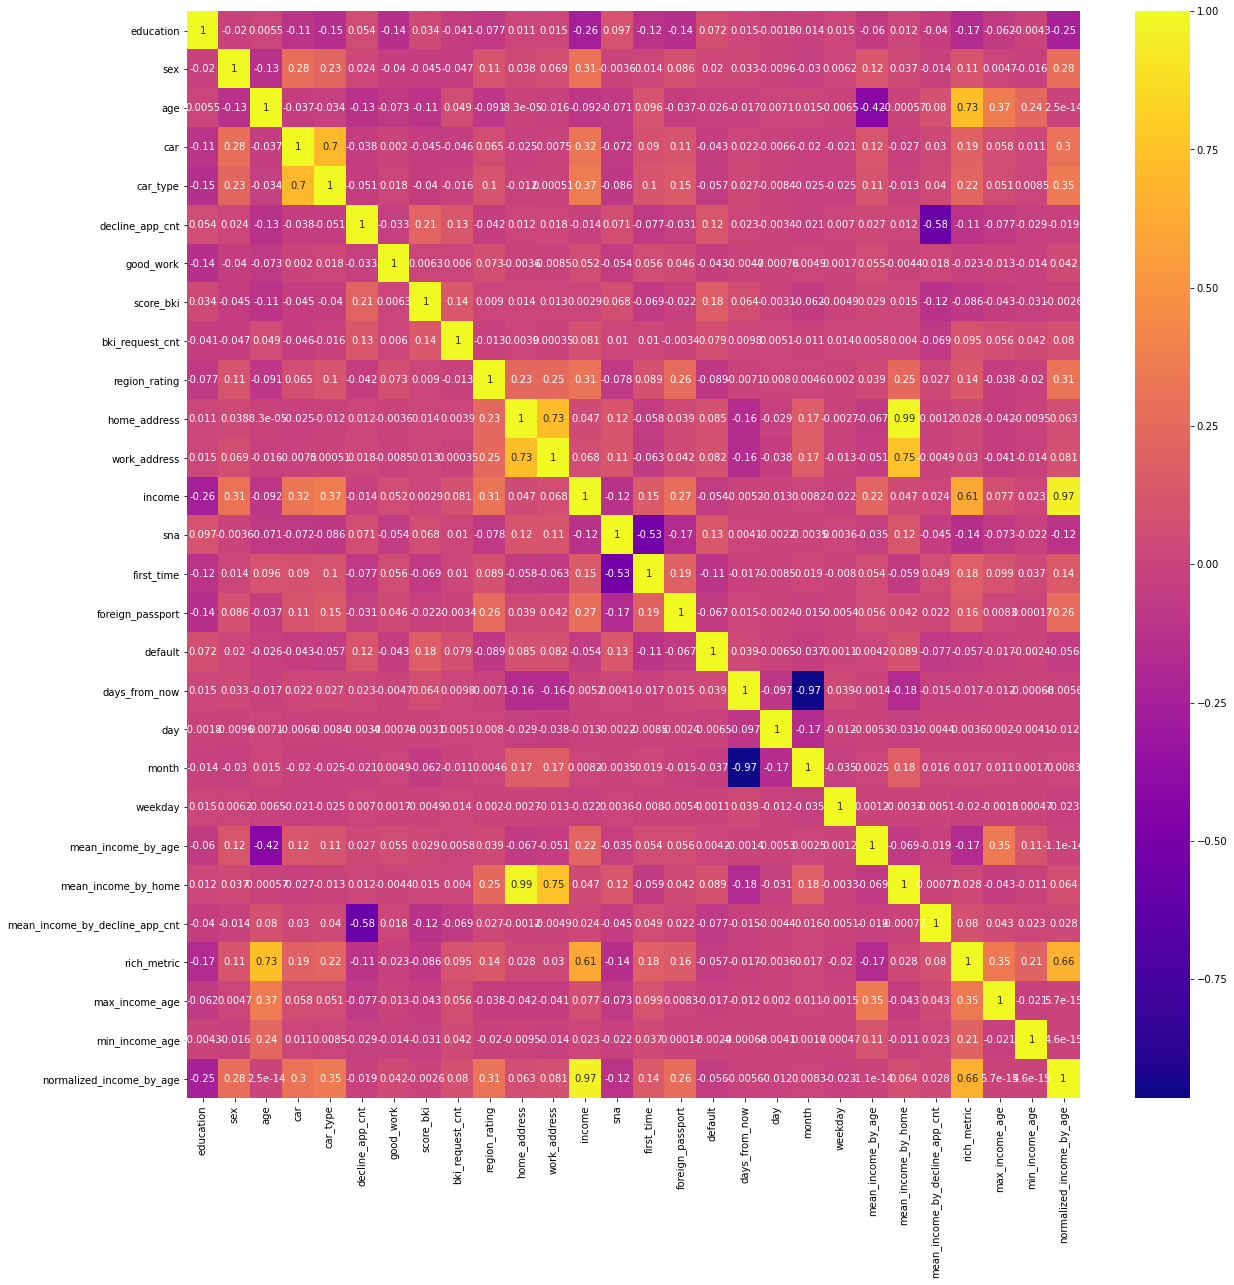

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(df_train.drop('client_id', axis=1).corr(),
                 annot=True, cmap='plasma')

In [52]:
num_cols = ['age',
            'decline_app_cnt',
            'score_bki',
            'bki_request_cnt',
            'income',
            'mean_income_by_age',
            'mean_income_by_home',
            'mean_income_by_decline_app_cnt',
            'rich_metric',
            'max_income_age',
            'min_income_age',
            'normalized_income_by_age',
            'days_from_now',
            'day', 'month', 'weekday']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']

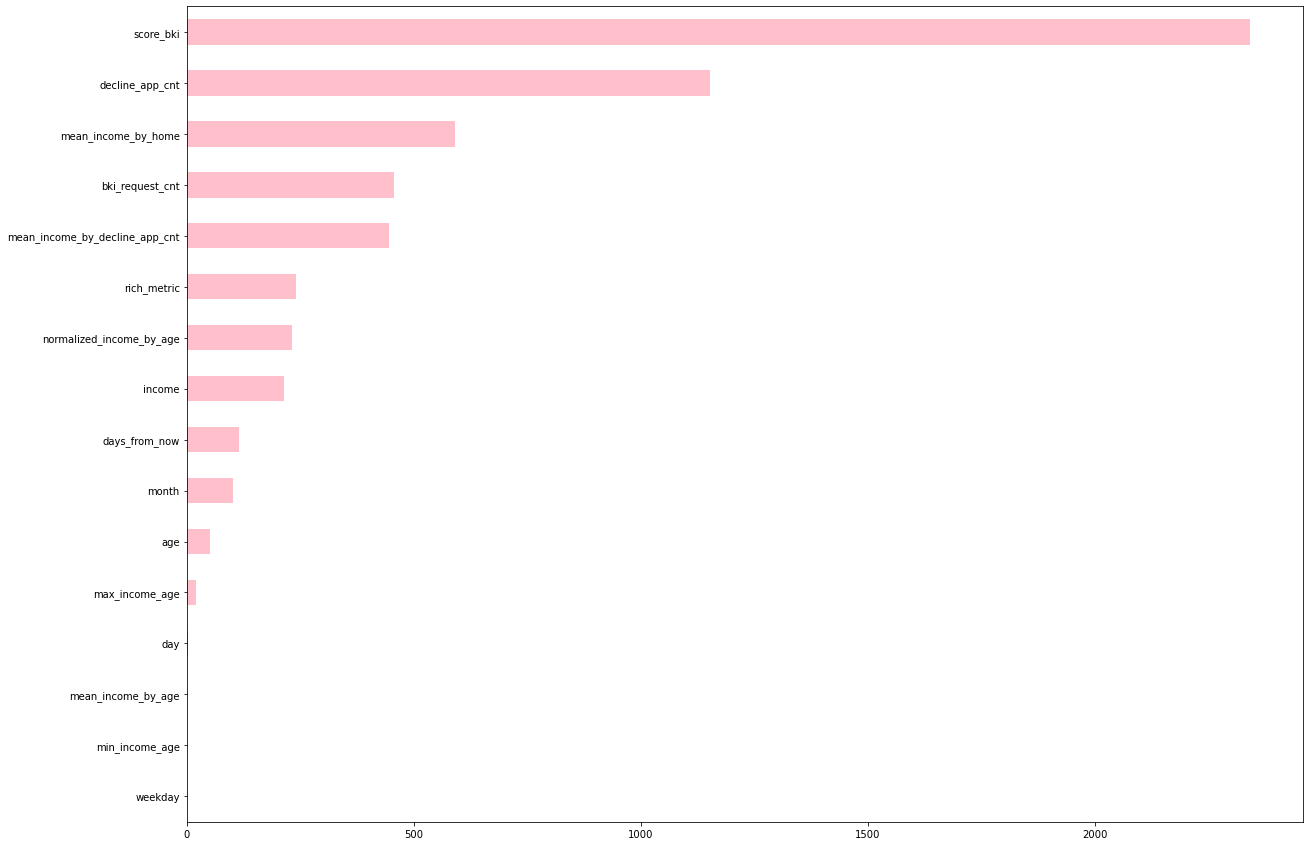

In [53]:
plt.figure(figsize=[20,15])
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='pink');

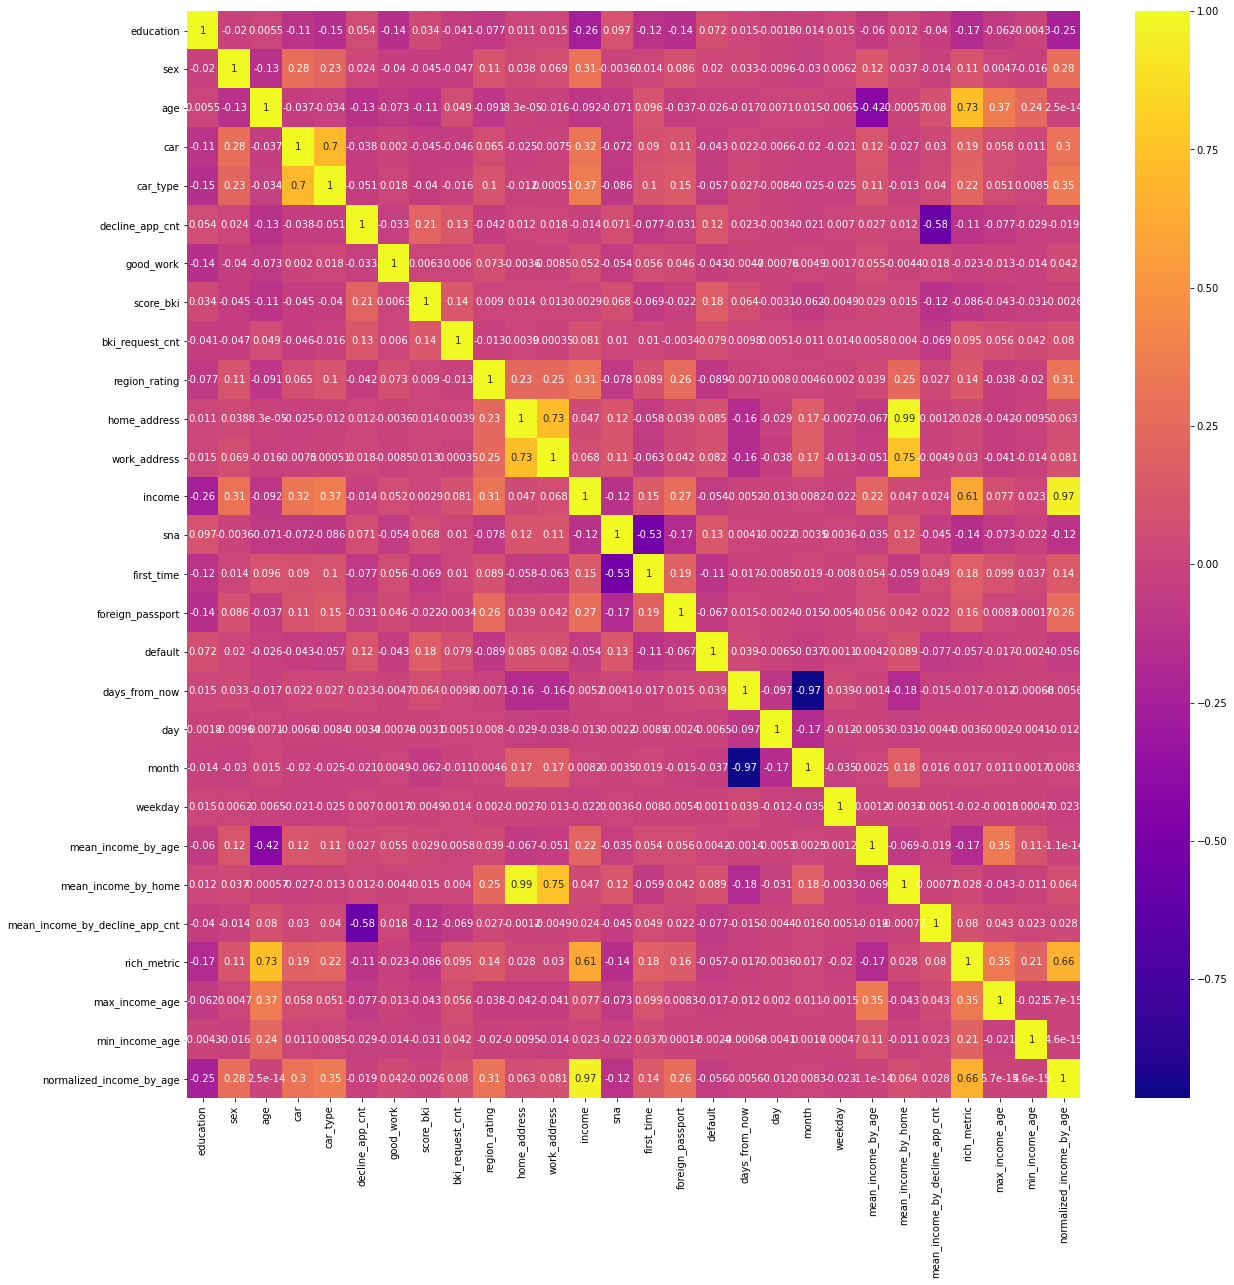

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(df_train.drop(['client_id'], axis=1).corr(), annot=True, cmap='plasma')

In [55]:
# # extract two columns from dataset
# data1 = df_train[['work_address', 'home_address']].values
# data2 = df_test[['work_address', 'home_address']].values

# # create Scaler instance
# scaler = StandardScaler()
# scaled_data1 = scaler.fit_transform(data1)
# scaled_data2 = scaler.fit_transform(data2)

# # We have two vectors. Reduce plane to line, taking most important info.
# pca1 = PCA(n_components=1)
# pca1.fit(scaled_data1)
# pca_data1 = pca1.transform(scaled_data1)
# df_train['pca_address'] = pca_data1

# pca2 = PCA(n_components=1)
# pca2.fit(scaled_data2)
# pca_data2 = pca2.transform(scaled_data2)
# df_test['pca_address'] = pca_data2


In [56]:
# # extract two columns from dataset
# data1 = df_train[['car', 'car_type']].values
# data2 = df_test[['car', 'car_type']].values

# # create Scaler instance
# scaler = StandardScaler()
# scaled_data1 = scaler.fit_transform(data1)
# scaled_data2 = scaler.fit_transform(data2)

# # We have two vectors. Reduce plane to line, taking most important info.
# pca1 = PCA(n_components=1)
# pca1.fit(scaled_data1)
# pca_data1 = pca1.transform(scaled_data1)
# df_train['pca_car'] = pca_data1

# pca2 = PCA(n_components=1)
# pca2.fit(scaled_data2)
# pca_data2 = pca2.transform(scaled_data2)
# df_test['pca_car'] = pca_data2


In [57]:
num_cols = ['age',
            'decline_app_cnt',
            'score_bki',
            'bki_request_cnt',
            'income',
            'mean_income_by_decline_app_cnt',
            'rich_metric',
            'max_income_age',
            'normalized_income_by_age',
            'days_from_now', 'month']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']

In [58]:
df1 = df_train.drop(['client_id', 'day', 'weekday', 'mean_income_by_age', 'mean_income_by_home',
                     'min_income_age'], axis=1)
df2 = df_test.drop(['client_id', 'day', 'weekday', 'mean_income_by_age', 'mean_income_by_home',
                    'min_income_age'], axis=1)

In [59]:
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols].values)
df2[num_cols] = scaler.fit_transform(df2[num_cols].values)

# scaler = MinMaxScaler()
# df1[num_cols] = scaler.fit_transform(df1[num_cols].values)
# df2[num_cols] = scaler.fit_transform(df2[num_cols].values)

# scaler = RobustScaler()
# df1[num_cols] = scaler.fit_transform(df1[num_cols].values)
# df2[num_cols] = scaler.fit_transform(df2[num_cols].values)

In [60]:
df1 = pd.get_dummies(df1, prefix=cat_cols, columns=cat_cols, drop_first=True)
df2 = pd.get_dummies(df2, prefix=cat_cols, columns=cat_cols, drop_first=True)

In [61]:
train = df1.drop(['app_date'], axis=1)
test = df2.drop(['app_date'], axis=1)

In [62]:
train

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,days_from_now,month,mean_income_by_decline_app_cnt,rich_metric,max_income_age,normalized_income_by_age,education_1,education_2,education_3,education_4,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_2,home_address_3,work_address_2,work_address_3,sna_2,sna_3,sna_4,first_time_2,first_time_3,first_time_4
0,1,1.704528,1,1,-0.420012,0,-0.208799,-0.281005,-0.785007,0,0,0.935052,-0.493121,0.285790,0.775393,-1.843079,-0.238301,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,1.535150,0,0,-0.420012,0,0.747545,0.772607,-0.707516,0,0,-0.279082,0.425076,0.285790,0.704940,0.767795,-0.188195,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
2,1,-1.397265,1,0,2.606733,0,0.996696,-0.281005,-0.052875,1,0,0.935052,-0.493121,-1.834887,-1.149785,-0.273068,-0.001446,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
3,0,1.168896,0,0,-0.420012,0,-0.306582,0.335319,-1.627442,0,0,1.215237,-1.411318,0.285790,-0.251672,0.883976,-1.546373,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
4,1,0.830490,0,0,-0.420012,1,1.324697,-0.281005,-0.052875,1,0,-1.430952,1.343273,0.285790,0.634709,0.645330,-0.154642,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,0,0.610085,0,0,-0.420012,0,0.226120,0.772607,-0.866929,0,0,-0.030029,0.425076,0.285790,-0.115584,0.378546,-1.075496,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
73795,1,0.292172,1,1,-0.420012,0,-0.307702,-0.281005,1.161500,0,0,-0.652661,0.425076,0.285790,1.038459,0.883976,0.957683,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
73796,1,-0.662638,0,0,-0.420012,0,0.786967,1.111795,0.528250,0,0,-1.555479,1.343273,0.285790,-0.191851,0.645330,0.342943,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0
73797,0,-0.890396,0,0,-0.420012,1,0.853806,0.772607,-1.251413,0,1,1.806738,-1.411318,0.285790,-1.490997,-1.191465,-1.645717,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0


In [63]:
test

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,days_from_now,month,mean_income_by_decline_app_cnt,rich_metric,max_income_age,normalized_income_by_age,education_1,education_2,education_3,education_4,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_2,home_address_3,work_address_2,work_address_3,sna_2,sna_3,sna_4,first_time_2,first_time_3,first_time_4
0,1,-0.882257,1,1,-0.416391,0,-0.732887,0.766434,0.682824,0,-0.599028,0.432200,0.273712,-0.280558,-0.133297,0.644781,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0.129766,0,0,4.588987,0,0.795510,0.330721,-2.632663,0,1.183197,-1.411484,-0.320219,-1.667912,0.698420,-2.609793,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,1,0.978493,1,1,-0.416391,0,0.424136,-0.283381,-0.052713,1,-0.630295,0.432200,0.273712,0.752760,-0.864932,-0.048465,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,1.365616,0,0,-0.416391,0,-0.936769,-0.283381,-0.870552,0,0.870526,-0.489642,0.273712,0.456188,0.698420,-0.614159,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0.041036,0,0,-0.416391,0,-1.162615,-1.333197,1.943409,0,0.839259,-0.489642,0.273712,1.339946,0.024571,1.944613,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,0,-0.050061,0,0,1.519954,0,0.317238,0.766434,-1.050774,0,-0.880432,0.432200,-1.246149,-0.734556,-0.133297,-1.277486,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
36345,0,1.821750,1,1,-0.416391,0,-0.776530,0.766434,2.678946,0,-1.662110,1.354042,0.273712,3.520705,0.404882,3.423942,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
36346,1,-0.654444,0,0,2.652642,0,1.920053,-0.283381,0.945348,0,-0.849165,0.432200,-1.004601,0.076929,-1.016947,0.985629,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0
36347,0,-1.126356,0,0,1.519954,0,1.318886,0.330721,-0.052713,0,1.714738,-1.411484,-1.246149,-0.932244,1.072410,-0.095476,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0


In [64]:
# попробуем oversampling для устранения дисбаланса
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)  # объединяем

In [65]:
X = train.drop(['default'], axis=1).values
y = train['default'].values  # <--- target

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [67]:
# from sklearn.feature_selection import RFE
# lr = LogisticRegression(max_iter=1000)
# rfe = RFE(lr, 20)
# rfe = rfe.fit(X, y.ravel())
# print(rfe.support_)
# print(rfe.ranking_)


# RFE ухудшает значительно результат, не совсем понял почему
# как я понял этот метод наоборот призван улучшить или хотя бы не ухудшить результат

In [68]:
#X[:,rfe.support_]

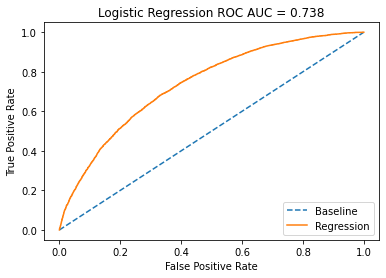

In [69]:
model = LogisticRegression(
    solver='liblinear', random_state=RANDOM_SEED, penalty='l2', max_iter=100, C=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

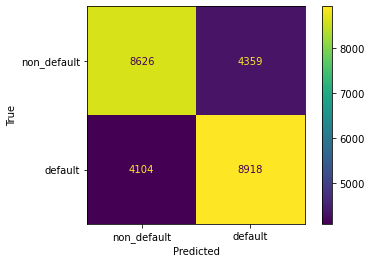

In [70]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [71]:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('precision_score: {}'.format(np.round(precision_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6746
f1_score: 0.6782
precision_score: 0.6717
recall_score: 0.6848
MSE: 0.3254


In [72]:
#  НЕ РАБОТАЕТ, ЗАВИСАЕТ КОМП

# from sklearn.model_selection import GridSearchCV

# # Добавим типы регуляризации
# penalty = ['l1', 'l2']

# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty)

# model = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED, max_iter=1000)
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

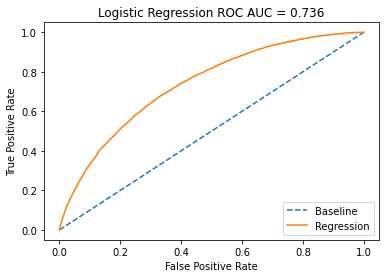

In [73]:
model = LogisticRegression(random_state=RANDOM_SEED,
                           penalty='l2', max_iter=1000, solver='liblinear')
model.fit(X, y)

probs = model.predict_proba(X)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y, probs)
roc_auc = roc_auc_score(y, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Submission

In [74]:
test

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,days_from_now,month,mean_income_by_decline_app_cnt,rich_metric,max_income_age,normalized_income_by_age,education_1,education_2,education_3,education_4,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_2,home_address_3,work_address_2,work_address_3,sna_2,sna_3,sna_4,first_time_2,first_time_3,first_time_4
0,1,-0.882257,1,1,-0.416391,0,-0.732887,0.766434,0.682824,0,-0.599028,0.432200,0.273712,-0.280558,-0.133297,0.644781,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0.129766,0,0,4.588987,0,0.795510,0.330721,-2.632663,0,1.183197,-1.411484,-0.320219,-1.667912,0.698420,-2.609793,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,1,0.978493,1,1,-0.416391,0,0.424136,-0.283381,-0.052713,1,-0.630295,0.432200,0.273712,0.752760,-0.864932,-0.048465,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,1.365616,0,0,-0.416391,0,-0.936769,-0.283381,-0.870552,0,0.870526,-0.489642,0.273712,0.456188,0.698420,-0.614159,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0.041036,0,0,-0.416391,0,-1.162615,-1.333197,1.943409,0,0.839259,-0.489642,0.273712,1.339946,0.024571,1.944613,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,0,-0.050061,0,0,1.519954,0,0.317238,0.766434,-1.050774,0,-0.880432,0.432200,-1.246149,-0.734556,-0.133297,-1.277486,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
36345,0,1.821750,1,1,-0.416391,0,-0.776530,0.766434,2.678946,0,-1.662110,1.354042,0.273712,3.520705,0.404882,3.423942,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
36346,1,-0.654444,0,0,2.652642,0,1.920053,-0.283381,0.945348,0,-0.849165,0.432200,-1.004601,0.076929,-1.016947,0.985629,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0
36347,0,-1.126356,0,0,1.519954,0,1.318886,0.330721,-0.052713,0,1.714738,-1.411484,-1.246149,-0.932244,1.072410,-0.095476,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0


In [75]:
predict_submission = model.predict_proba(test.values)

In [76]:
predict_submission.shape

(36349, 2)

In [77]:
results_df = pd.DataFrame(
    data={'client_id': df_test['client_id'], 'default': predict_submission[:, 1]})

In [78]:
sample_submission.shape

(24354, 2)

In [79]:
results_df

,client_id,default
0,74835,0.195930
1,17527,0.789636
2,75683,0.316692
3,26883,0.402008
4,28862,0.137613
...,...,...
36344,83775,0.786388
36345,106254,0.112689
36346,81852,0.777150
36347,1971,0.633514


In [80]:
results_df.to_csv('submission.csv', index=False)

1. Почему RFE ухудшает модель? Как им правильно пользоваться
2. GridSearch у меня не работает. Как тогда подбирать гиперпараметры?
3. Очень много признаков коррелирует друг с другом, но если удалить их то модель ухудшается? Как быть с ними? Почему их удаление приводит к ухудшению. По логике, должно быть наоборот.
4. Как правильно отбирать признаки. Если с Random Forest более менее понятно, то здесь я так и не понял.
5. Стоит ли удалять выбросы? Если не удалять то модель показывает результат лучше, поэтому я не стал их удалять.